# DDPM (Dyfuzja)

In [1]:
# from google.colab import drive
# import os

# drive.mount("/content/drive/")

# path = "/content/drive/MyDrive/Project_PGM/data"
# os.makedirs(path, exist_ok=True)
# os.chdir(path)

In [2]:
!pip install pytorch-lightning


[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

/mnt/d/Coding/Python/project-nature-inpainting/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading

### Data from JPG

In [4]:
class PairedImagesDataset(Dataset):
    """
    A PyTorch Dataset for loading paired images from directories.

    This Dataset loads paired images (corrupted and original) from directories.
    It applies a transform to the images if provided.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images.
    original_dir : Path
        The directory containing the original images.
    transform : callable, optional
        An optional transform to apply to the images.
    class_dirs : list
        The list of class directories.
    file_pairs : list
        The list of file pairs.

    Methods
    -------
    __len__()
        Return the number of images in the dataset.
    __getitem__(idx)
        Return the corrupted and original images at the given index.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, transform=None):
        """
        Initialize the Dataset.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images.
        original_dir : Path
            The directory containing the original images.
        transform : callable, optional
            An optional transform to apply to the images.
        """
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.transform = transform
        self.class_dirs = sorted(os.listdir(corrupted_dir))

        # Ensure the two directories have the same number of class directories
        assert len(self.class_dirs) == len(os.listdir(original_dir))

        self.file_pairs = [
            (class_dir, filename)
            for class_dir in self.class_dirs
            for filename in sorted(os.listdir(os.path.join(corrupted_dir, class_dir)))
        ]

    def __len__(self) -> int:
        """
        Return the number of images in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.file_pairs)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return the corrupted and original images at the given index.

        Parameters
        ----------
        idx : int
            The index of the images to return.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            The corrupted and original images at the given index.
        """
        # Load the corrupted and original images
        class_dir, filename = self.file_pairs[idx]

        # Load the corrupted and original images
        img_corrupted = Image.open(self.corrupted_dir / class_dir / filename)
        img_original = Image.open(self.original_dir / class_dir / filename)

        # Apply the transformations
        if self.transform:
            img_corrupted = self.transform(img_corrupted)
            img_original = self.transform(img_original)

        return img_corrupted, img_original

In [5]:
class PairedImagesDataModule(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading paired images from directories.

    This DataModule loads paired images (corrupted and original) from directories
    for training, validation, and testing.
    It applies a transform to the images and provides DataLoaders for the datasets.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images.
    original_dir : Path
        The directory containing the original images.
    batch_size : int
        The batch size for the DataLoaders.
    transform : torchvision.transforms.Compose
        The transform to apply to the images.

    Methods
    -------
    setup(stage=None)
        Prepare the datasets for the given stage.
    train_dataloader()
        Return a DataLoader for the training dataset.
    val_dataloader()
        Return a DataLoader for the validation dataset.
    test_dataloader()
        Return a DataLoader for the test dataset.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, batch_size: int = 32):
        """
        Initialize the DataModule.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images.
        original_dir : Path
            The directory containing the original images.
        batch_size : int, optional
            The batch size for the DataLoaders, by default 32.
        """
        super().__init__()
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

    def setup(self, stage=None):
        """
        Prepare the datasets for the given stage.

        This method is called by PyTorch Lightning during the setup stage.
        It prepares the datasets for the given stage (either 'fit', 'test', or None).

        Parameters
        ----------
        stage : str, optional
            The stage for which to prepare the datasets. If 'fit', the method prepares
            the training and validation datasets.
            If 'test', it prepares the test dataset. If None, it prepares all datasets.
        """
        if stage == "fit" or stage is None:
            self.paired_images_train = PairedImagesDataset(
                self.corrupted_dir / "train",
                self.original_dir / "train",
                transform=self.transform,
            )
            self.paired_images_val = PairedImagesDataset(
                self.corrupted_dir / "val",
                self.original_dir / "val",
                transform=self.transform,
            )

        if stage == "test" or stage is None:
            self.paired_images_test = PairedImagesDataset(
                self.corrupted_dir / "test",
                self.original_dir / "test",
                transform=self.transform,
            )

    def train_dataloader(self):
        """
        Return a DataLoader for the training dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the training dataset.
        """
        return DataLoader(
            self.paired_images_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=-1,
        )

    def val_dataloader(self):
        """
        Return a DataLoader for the validation dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the validation dataset.
        """
        return DataLoader(
            self.paired_images_val, batch_size=self.batch_size, num_workers=-1
        )

    def test_dataloader(self):
        """
        Return a DataLoader for the test dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the test dataset.
        """
        return DataLoader(
            self.paired_images_test, batch_size=self.batch_size, num_workers=-1
        )

In [6]:
# original_dir = Path("data/divided_x64")
# corrupted_dir = Path("data/augmented_x64")

# data_module = PairedImagesDataModule(corrupted_dir, original_dir, batch_size=32)
# data_module.setup()

# train_loader = data_module.train_dataloader()
# val_loader = data_module.val_dataloader()
# test_loader = data_module.test_dataloader()

### Data from Pickle

In [7]:
class PairedImagesDatasetPickle(Dataset):
    """
    A PyTorch Dataset for loading paired images from pickle files.

    This Dataset loads paired images (corrupted and original) from pickle files.
    It applies a transform to the images if provided.

    Attributes
    ----------
    corrupted_file : Path
        The pickle file containing the corrupted images.
    original_file : Path
        The pickle file containing the original images.
    transform : callable, optional
        An optional transform to apply to the images.

    Methods
    -------
    __len__()
        Return the number of images in the dataset.
    __getitem__(idx)
        Return the corrupted and original images at the given index.
    """

    def __init__(self, corrupted_file: Path, original_file: Path, transform=None):
        """
        Initialize the Dataset.

        Parameters
        ----------
        corrupted_file : Path
            The pickle file containing the corrupted images.
        original_file : Path
            The pickle file containing the original images.
        transform : callable, optional
            An optional transform to apply to the images.
        """
        self.corrupted_file = corrupted_file
        self.original_file = original_file
        self.transform = transform

        # Load the images from the pickle files
        with open(corrupted_file, "rb") as f:
            self.corrupted_images = pickle.load(f)
        with open(original_file, "rb") as f:
            self.original_images = pickle.load(f)

        # Ensure the two files have the same number of images
        assert len(self.corrupted_images) == len(self.original_images)

    def __len__(self) -> int:
        """
        Return the number of images in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.corrupted_images)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Return the corrupted and original images at the given index.

        Parameters
        ----------
        idx : int
            The index of the images to return.

        Returns
        -------
        tuple[torch.Tensor, torch.Tensor]
            The corrupted and original images at the given index.
        """
        # Load the corrupted and original images
        img_corrupted = self.corrupted_images[idx]
        img_original = self.original_images[idx]

        # Convert the numpy arrays to PIL Images
        img_corrupted = Image.fromarray(img_corrupted)
        img_original = Image.fromarray(img_original)

        # Apply the transformations
        if self.transform:
            img_corrupted = self.transform(img_corrupted)
            img_original = self.transform(img_original)

        return img_corrupted, img_original

In [8]:
class PairedImagesDataModulePickle(pl.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading paired images from pickle files.

    This DataModule loads paired images (corrupted and original) from pickle files
    for training, validation, and testing.
    It applies a transform to the images and provides DataLoaders for the datasets.

    Attributes
    ----------
    corrupted_dir : Path
        The directory containing the corrupted images pickle files.
    original_dir : Path
        The directory containing the original images pickle files.
    batch_size : int
        The batch size for the DataLoaders.
    transform : torchvision.transforms.Compose
        The transform to apply to the images.

    Methods
    -------
    setup(stage=None)
        Prepare the datasets for the given stage.
    train_dataloader()
        Return a DataLoader for the training dataset.
    val_dataloader()
        Return a DataLoader for the validation dataset.
    test_dataloader()
        Return a DataLoader for the test dataset.
    """

    def __init__(self, corrupted_dir: Path, original_dir: Path, batch_size: int = 32):
        """
        Initialize the DataModule.

        Parameters
        ----------
        corrupted_dir : Path
            The directory containing the corrupted images in pickle files.
        original_dir : Path
            The directory containing the original images in pickle files.
        batch_size : int, optional
            The batch size for the DataLoaders, by default 32.
        """
        super().__init__()
        self.corrupted_dir = corrupted_dir
        self.original_dir = original_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )

    def setup(self, stage=None):
        """
        Prepare the datasets for the given stage.

        This method is called by PyTorch Lightning during the setup stage.
        It prepares the datasets for the given stage (either 'fit', 'test', or None).

        Parameters
        ----------
        stage : str, optional
            The stage for which to prepare the datasets. If 'fit', the method prepares
            the training and validation datasets.
            If 'test', it prepares the test dataset. If None, it prepares all datasets.
        """
        if stage == "fit" or stage is None:
            self.paired_images_train = PairedImagesDatasetPickle(
                self.corrupted_dir / "train.pkl",
                self.original_dir / "train.pkl",
                transform=self.transform,
            )
            self.paired_images_val = PairedImagesDatasetPickle(
                self.corrupted_dir / "val.pkl",
                self.original_dir / "val.pkl",
                transform=self.transform,
            )

        if stage == "test" or stage is None:
            self.paired_images_test = PairedImagesDatasetPickle(
                self.corrupted_dir / "test.pkl",
                self.original_dir / "test.pkl",
                transform=self.transform,
            )

    def train_dataloader(self):
        """
        Return a DataLoader for the training dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the training dataset.
        """
        return DataLoader(
            self.paired_images_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=os.cpu_count(),
            pin_memory=True,
        )

    def val_dataloader(self):
        """
        Return a DataLoader for the validation dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the validation dataset.
        """
        return DataLoader(
            self.paired_images_val,
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            pin_memory=True,
            shuffle=True,
        )

    def test_dataloader(self):
        """
        Return a DataLoader for the test dataset.

        Returns
        -------
        DataLoader
            A DataLoader for the test dataset.
        """
        return DataLoader(
            self.paired_images_test,
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            pin_memory=True,
            shuffle=True,
        )

In [9]:
original_dir = Path("data/divided_x64")
corrupted_dir = Path("data/augmented_x64_no")

data_module_pickle = PairedImagesDataModulePickle(
    corrupted_dir, original_dir, batch_size=32
)
data_module_pickle.setup()

train_loader_pickle = data_module_pickle.train_dataloader()
val_loader_pickle = data_module_pickle.val_dataloader()
test_loader_pickle = data_module_pickle.test_dataloader()

# Executes on colab: ~2 min

In [10]:
# batch = next(iter(train_loader_pickle))
# img = batch[0][0].permute(1, 2, 0)
# # img = torch.clip(img, -1, 1)
# # img = (img + 1) / 2
# plt.imshow(img.numpy())
# img.min(), img.max()


# DDPM model

In [11]:
from diffusers.models.unets import UNet2DModel

class UNetDDPM(torch.nn.Module):
    def __init__(self, channels=[32, 64, 96, 128]):
        super().__init__()
        self.channels = channels
        self.layers_per_block = 2
        self.downblock = 'ResnetDownsampleBlock2D'
        self.upblock = 'ResnetUpsampleBlock2D'
        self.add_attention = True
        self.attention_head_dim = 32

        self.unet = UNet2DModel(
            in_channels=6,
            out_channels=3,
            block_out_channels=self.channels, 
            layers_per_block=self.layers_per_block,
            down_block_types=tuple(self.downblock for _ in range(len(self.channels))),
            up_block_types=tuple(self.upblock for _ in range(len(self.channels))),
            add_attention=self.add_attention, 
            attention_head_dim=self.attention_head_dim,
        )

    def forward(self, x_t, img_crop, t):
        return self.unet(
            torch.cat([x_t, img_crop], dim=1),
            timestep=t.float() # pomyśleć jak to zastąpić alphą
        ).sample# + x

/mnt/d/Coding/Python/project-nature-inpainting/.venv/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [12]:
unet_model = UNetDDPM([64, 96, 128])

# show num of parameters
num_params = sum(p.numel() for p in unet_model.parameters())
print(f'Number of parameters: {num_params}')

Number of parameters: 5580131


In [13]:
import math
def beta_schedule_linear(num_diffusion_timesteps):
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return np.linspace(
        beta_start**0.5, beta_end**0.5, num_diffusion_timesteps, dtype=np.float64
    ) ** 2
    

def beta_schedule_cosine(num_diffusion_timesteps):
    betas = []
    for i in range(num_diffusion_timesteps):
        max_beta=0.999
        t1 = float(i) / num_diffusion_timesteps
        t2 = float(i + 1) / num_diffusion_timesteps
        alpha = lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2
        betas.append(min(1 - alpha(t2) / alpha(t1), max_beta))
    return np.array(betas)
    
    
def apply(factors, timesteps, x, multiply=True):
    """
    Extract values from factors with certain timesteps and apply them to x.

    :param factors: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param x: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = torch.from_numpy(factors).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(x.shape):
        res = res[..., None]
    return (res.expand(x.shape) * x) if multiply else res.expand(x.shape)

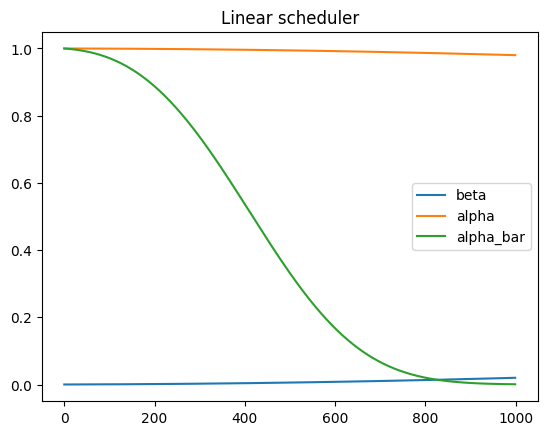

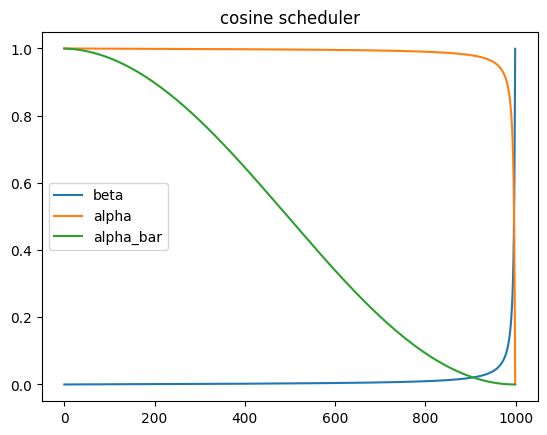

In [14]:
# beta = get_named_beta_schedule("linear", 1000)
beta = beta_schedule_linear(1000)
alpha = 1 - beta
alpha_bar = np.cumprod(alpha)

plt.plot(beta, label='beta')
plt.plot(alpha, label='alpha')
plt.plot(alpha_bar, label='alpha_bar')

plt.legend()
plt.title("Linear scheduler")

plt.show()

beta = beta_schedule_cosine(1000)
alpha = 1 - beta
alpha_bar = np.cumprod(alpha)

plt.plot(beta, label='beta')
plt.plot(alpha, label='alpha')
plt.plot(alpha_bar, label='alpha_bar')

plt.legend()
plt.title("cosine scheduler")

plt.show()

In [15]:
class Diffusion:
    def __init__(self, timesteps=1000, beta_type='cosine'):
        self.timesteps = timesteps
        if beta_type == 'cosine':
            self.beta = beta_schedule_cosine(self.timesteps)
        elif beta_type == 'linear':
            self.beta = beta_schedule_linear(self.timesteps)
        self.alpha = 1 - self.beta
        self.alpha_bar = np.cumprod(self.alpha)
        self.alpha_bar_prev = np.concatenate([np.array([1]), self.alpha_bar[:-1]])

    def forward(self, x_0, t, epsilon=None):
        if epsilon is None:
            epsilon = torch.randn_like(x_0)

        x_t = apply(np.sqrt(self.alpha_bar), t, x_0) + apply(np.sqrt(1 - self.alpha_bar), t, epsilon) # we add noise to x_0
        return x_t


    def compute_loss(self, unet, x_0, img_crop):
        # sample timesteps
        timesteps = torch.randint(0, self.timesteps, (x_0.shape[0],), device=x_0.device, dtype=torch.long)
        # sample epsilon
        epsilon = torch.randn_like(x_0, device=x_0.device, dtype=x_0.dtype)
        x_t = self.forward(x_0, timesteps, epsilon)
        
        
        pred_x_0 = unet(x_t, img_crop, timesteps)
        mse = (pred_x_0 - x_0).pow(2).mean(dim=(1,2,3)) # loss
        loss = apply(np.sqrt(self.alpha_bar), timesteps, mse).mean()

        return loss
    
    def posterior(self, x_t, x_0, t, epsilon=None):
        if epsilon is None:
            epsilon = torch.randn_like(x_0)

        x_prev = ( 
            apply((np.sqrt(self.alpha_bar_prev)*self.beta) / (1 - self.alpha_bar), t, x_0) + 
            apply((np.sqrt(self.alpha) * (1 - self.alpha_bar_prev)) / (1 - self.alpha_bar), t, x_t) + 
            apply(np.sqrt((1 - self.alpha_bar_prev) / (1 - self.alpha_bar) * self.beta), t, epsilon)
        )

        return x_prev

    def sample(self, unet, img_crop, sample_size=(1, 3, 64, 64)):
        with torch.no_grad():
            x_t = torch.randn(sample_size, device=unet.unet.device)
            
            timesteps = list(range(self.timesteps))[::-1]

            print('\nsampling loop')

            for i in timesteps:
                t = torch.Tensor([i] * x_t.shape[0]).long().to(x_t.device)

                pred_x_0 = torch.clamp(unet(x_t, img_crop, t), -1, 1)

                if i > 0:
                    x_t = self.posterior(x_t, pred_x_0, t)
                    
                else:
                    x_t = pred_x_0

        return x_t.detach().cpu()
    

tensor(-1.) tensor(0.9294)
tensor(-1.1914) tensor(1.0586)


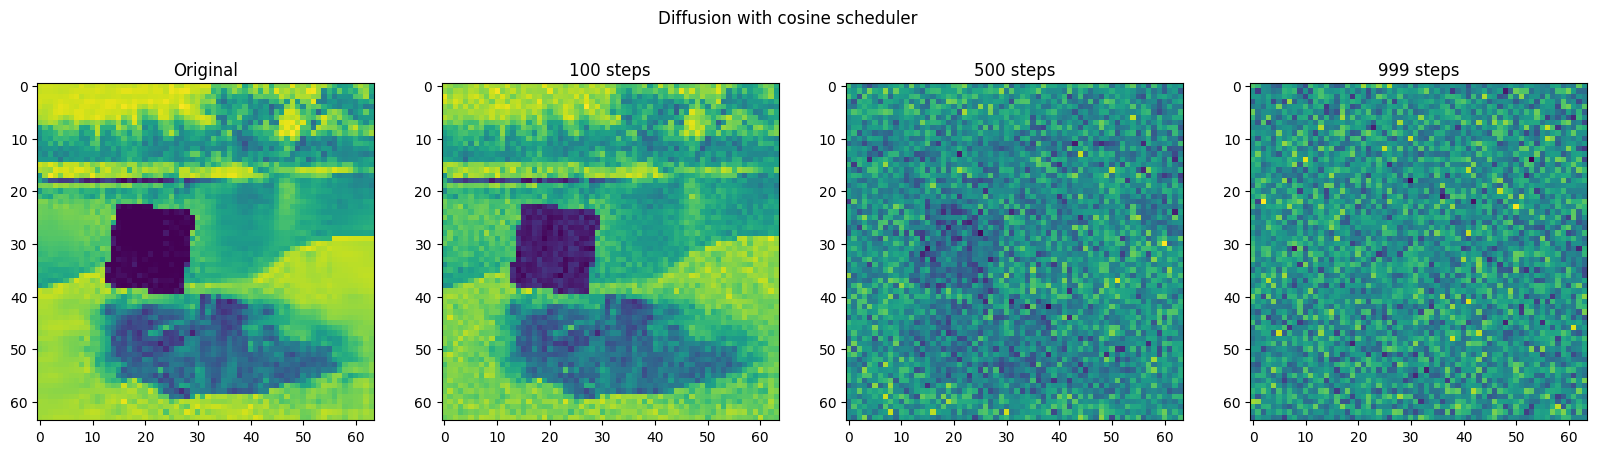

tensor(-1.3128) tensor(1.0924)


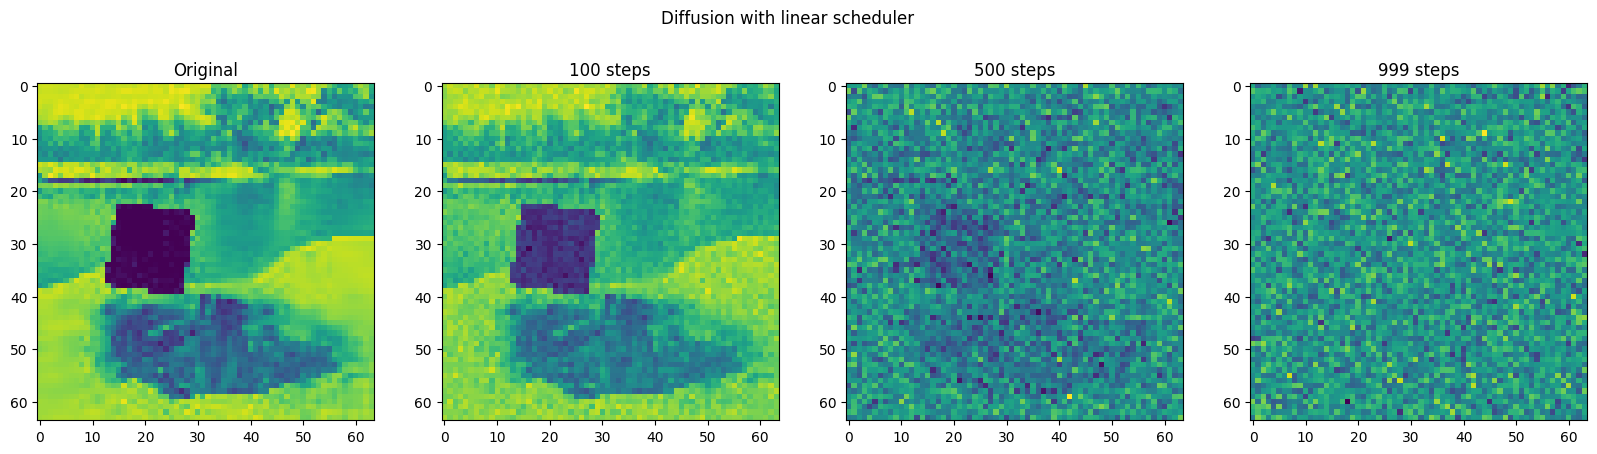

In [16]:
# get image from mnist

batch = next(iter(train_loader_pickle))
img = batch[0][0]

print(img.min(), img.max())

for scheduler in ['cosine', 'linear']:
    diffusion = Diffusion(timesteps=1000)

    x_1 = (diffusion.forward(2*img-1, torch.tensor([100])) + 1.0) * 0.5
    x_2 = (diffusion.forward(img, torch.tensor([500])) + 1.0) * 0.5
    x_3 = (diffusion.forward(img, torch.tensor([999])) + 1.0) * 0.5
    print(x_1.min(), x_1.max())
    # plot original and diffused image in subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(img[0])
    axs[0].set_title('Original')
    axs[1].imshow(x_1[0])
    axs[1].set_title('100 steps')
    axs[2].imshow(x_2[0])
    axs[2].set_title('500 steps')
    axs[3].imshow(x_3[0])
    axs[3].set_title('999 steps')
    plt.suptitle(f'Diffusion with {scheduler} scheduler')
    plt.show()


In [19]:
class ModelLit(pl.LightningModule):
    def __init__(self, unet_model, diffusion, lr=1e-4):
        super().__init__()
        self.unet = unet_model
        self.diffusion = diffusion
        self.lr = lr
        self.loss_log = []

    def forward(self, x, t):
        raise NotImplementedError('Forward method is not implemented')

    def training_step(self, batch, batch_idx):
        crop_img, x_0 = batch

        # x_0 = 2*x_0 - 1.0

        #loss = self.diffusion.compute_loss(self.unet, x_0, y)
        loss = self.diffusion.compute_loss(self.unet, x_0, crop_img)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    
    
    def validation_step(
        self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        """
        Perform a validation step.

        Parameters
        ----------
        batch : tuple[torch.Tensor, torch.Tensor]
            The input and target tensors for the batch.
        batch_idx : int
            The index of the batch.

        Returns
        -------
        dict
            A dictionary with the loss for the step.
        """
        img_crop, x_0 = batch
        img_crop, x_0 = img_crop.to(self.device), x_0.to(self.device)
        shape = img_crop.shape
        pred_x_0 = self.diffusion.sample(self.unet, img_crop, sample_size=shape)
        
        fig, axs = plt.subplots(2, 5, figsize=(10, 4))
        for i in range(5):
            num = np.random.randint(0, shape[0])
            
            pred_x_0_plot  = torch.clip(pred_x_0[num], -1, 1)
            pred_x_0_plot = pred_x_0_plot.detach().cpu().numpy().transpose(1, 2, 0)
            pred_x_0_plot = (pred_x_0_plot + 1) / 2  # Normalize to [0, 1]
            # print(y_pred_plot.min(), y_pred_plot.max())
            
            x_0_true = x_0[num].detach().cpu().numpy().transpose(1, 2, 0)
            x_0_true = (x_0_true + 1) / 2  # Normalize to [0, 1]
            # print(y_true.min(), y_true.max())
            
            axs[0, i].imshow(x_0_true)
            axs[0, i].set_title("Ground Truth x_0")
            axs[0, i].set_xticks([])
            axs[0, i].set_yticks([])
            axs[1, i].imshow(pred_x_0_plot)
            axs[1, i].set_title("Predicted x_0")
            axs[1, i].set_xticks([])
            axs[1, i].set_yticks([])
        plt.suptitle(f"Epoch {self.current_epoch}")
        plt.show()
        
        # self.loss_log.append(self.diffusion.compute_loss(self.unet, x_0, img_crop).item())
    

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.unet.parameters(), lr=self.lr)
        return optimizer

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | unet | UNetDDPM | 3.9 M 
----------------------------------
3.9 M     Trainable params
0         Non-trainable params
3.9 M     Total params
15.516    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/mnt/d/Coding/Python/project-nature-inpainting/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
sampling loop


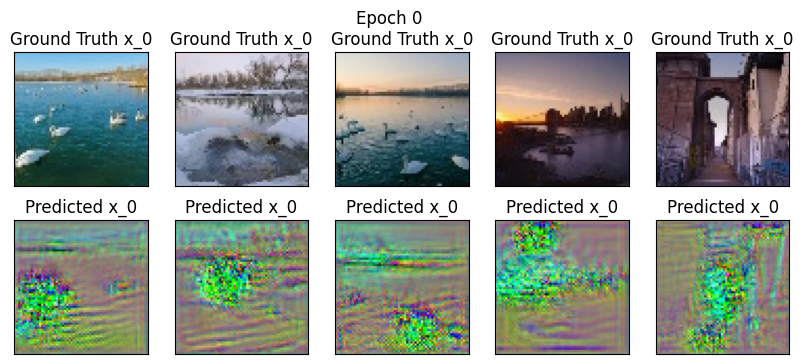

Epoch 0: 100%|██████████| 1894/1894 [01:59<00:00, 15.81it/s, v_num=18, train_loss_step=0.00334]
sampling loop


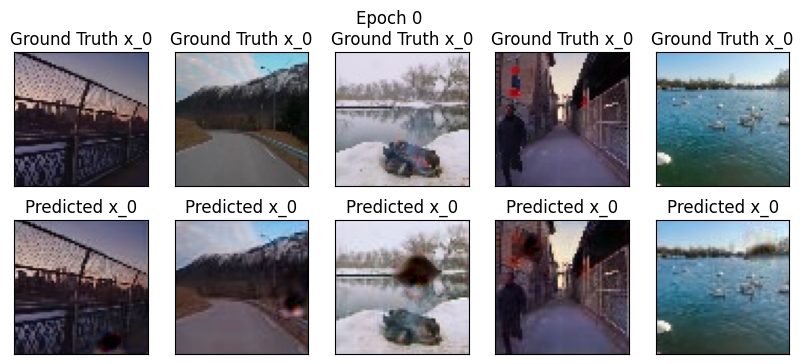

Epoch 1: 100%|██████████| 1894/1894 [01:59<00:00, 15.89it/s, v_num=18, train_loss_step=0.00341, train_loss_epoch=0.0122]
sampling loop


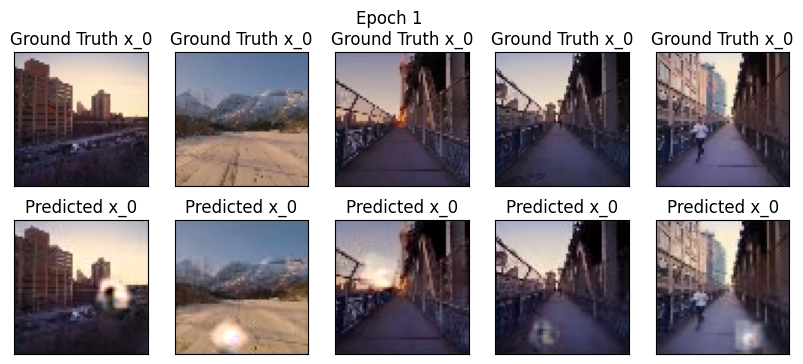

Epoch 2: 100%|██████████| 1894/1894 [01:59<00:00, 15.85it/s, v_num=18, train_loss_step=0.00289, train_loss_epoch=0.00342]
sampling loop


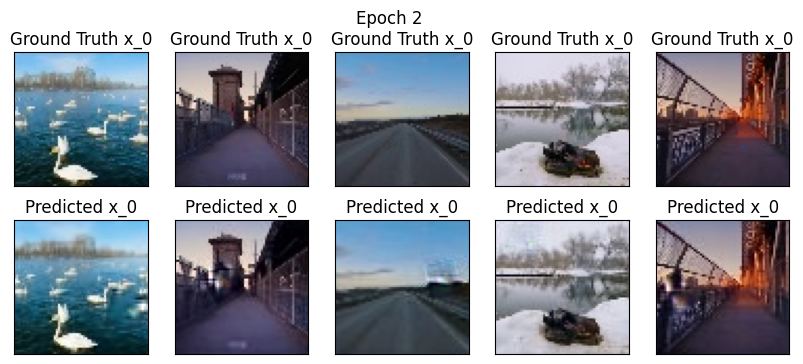

Epoch 3: 100%|██████████| 1894/1894 [01:59<00:00, 15.85it/s, v_num=18, train_loss_step=0.00159, train_loss_epoch=0.00285]
sampling loop


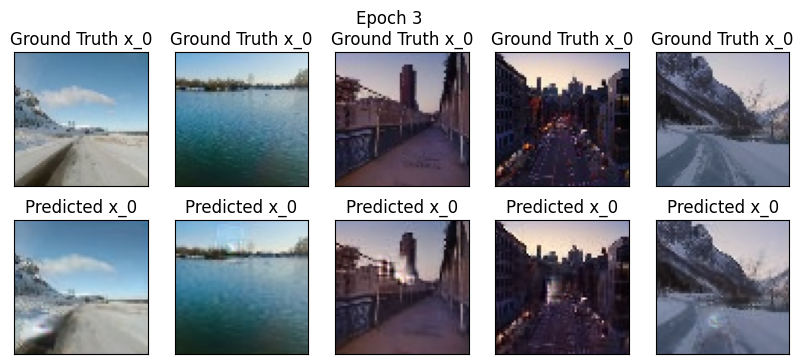

Epoch 4: 100%|██████████| 1894/1894 [01:59<00:00, 15.85it/s, v_num=18, train_loss_step=0.00141, train_loss_epoch=0.00253]
sampling loop


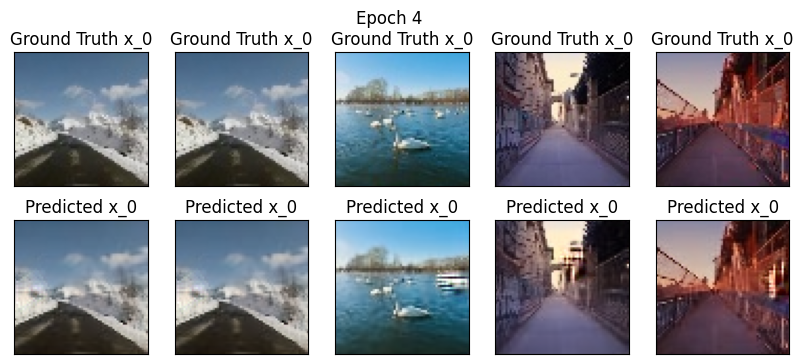

Epoch 5: 100%|██████████| 1894/1894 [01:59<00:00, 15.78it/s, v_num=18, train_loss_step=0.00186, train_loss_epoch=0.00232]
sampling loop


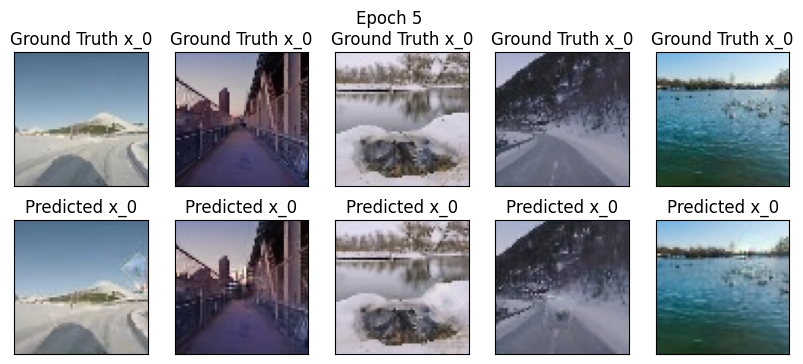

Epoch 6: 100%|██████████| 1894/1894 [02:00<00:00, 15.75it/s, v_num=18, train_loss_step=0.00208, train_loss_epoch=0.00224]
sampling loop


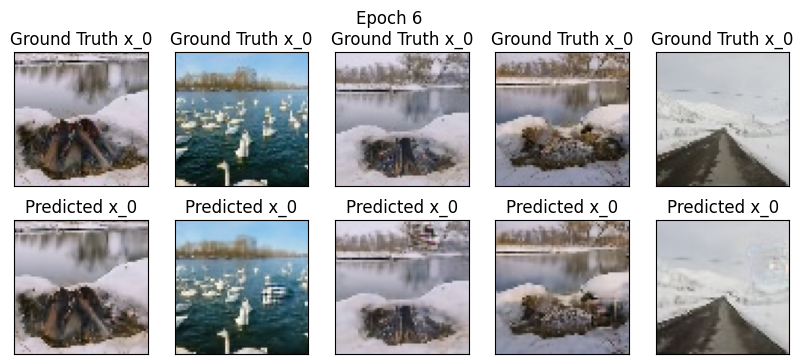

Epoch 7: 100%|██████████| 1894/1894 [02:00<00:00, 15.74it/s, v_num=18, train_loss_step=0.00181, train_loss_epoch=0.00208]
sampling loop


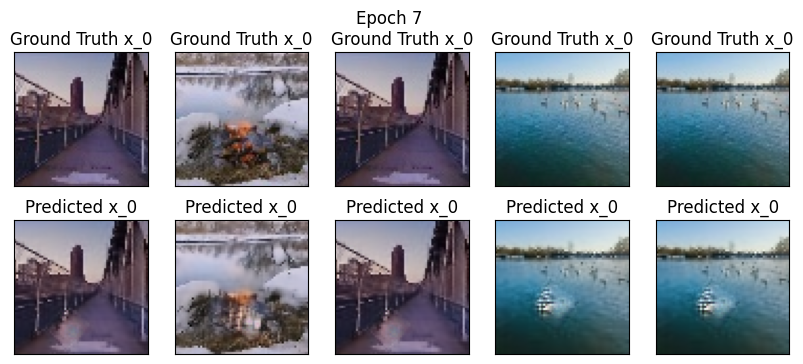

Epoch 8: 100%|██████████| 1894/1894 [01:59<00:00, 15.80it/s, v_num=18, train_loss_step=0.00189, train_loss_epoch=0.00199]
sampling loop


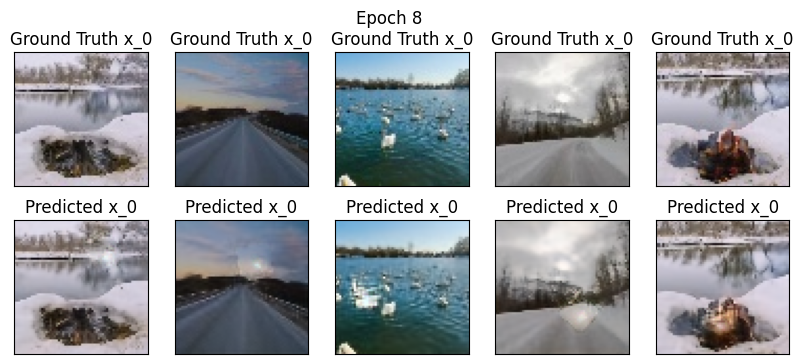

Epoch 9: 100%|██████████| 1894/1894 [01:59<00:00, 15.82it/s, v_num=18, train_loss_step=0.00317, train_loss_epoch=0.0019] 
sampling loop


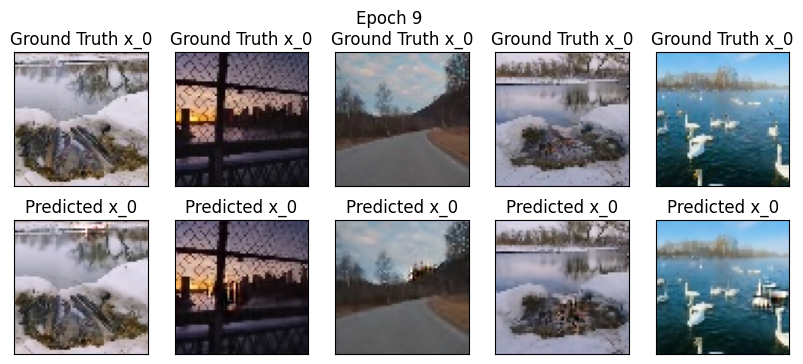

Epoch 10: 100%|██████████| 1894/1894 [02:00<00:00, 15.77it/s, v_num=18, train_loss_step=0.00193, train_loss_epoch=0.00183]
sampling loop


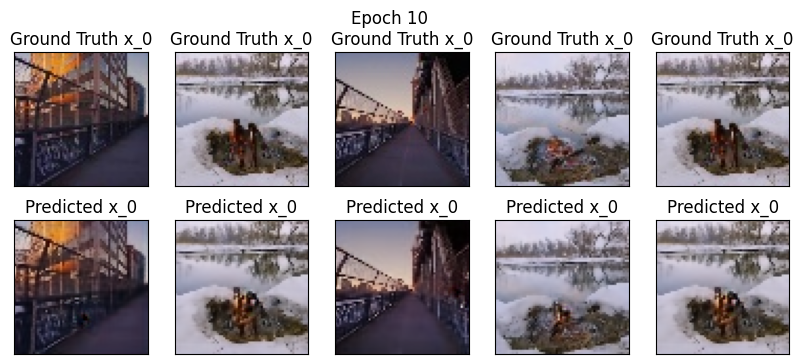

Epoch 11: 100%|██████████| 1894/1894 [01:59<00:00, 15.80it/s, v_num=18, train_loss_step=0.00103, train_loss_epoch=0.00175]
sampling loop


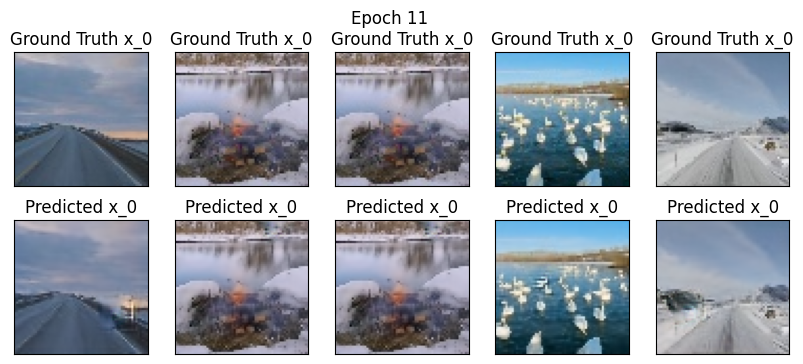

Epoch 12: 100%|██████████| 1894/1894 [01:59<00:00, 15.86it/s, v_num=18, train_loss_step=0.00148, train_loss_epoch=0.00169]
sampling loop


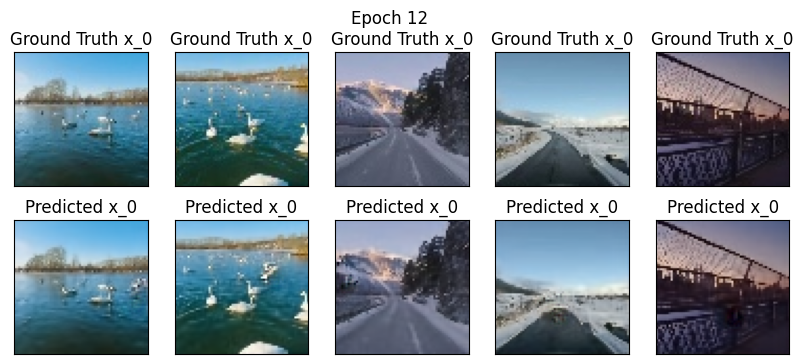

Epoch 13: 100%|██████████| 1894/1894 [01:51<00:00, 17.03it/s, v_num=18, train_loss_step=0.000803, train_loss_epoch=0.00166]
sampling loop


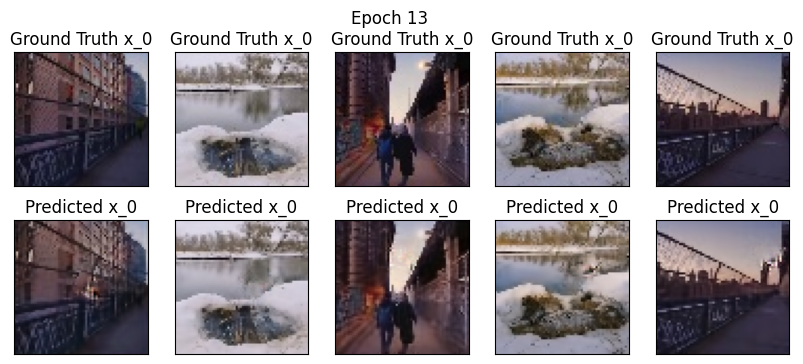

Epoch 14: 100%|██████████| 1894/1894 [01:50<00:00, 17.19it/s, v_num=18, train_loss_step=0.00103, train_loss_epoch=0.00167] 
sampling loop


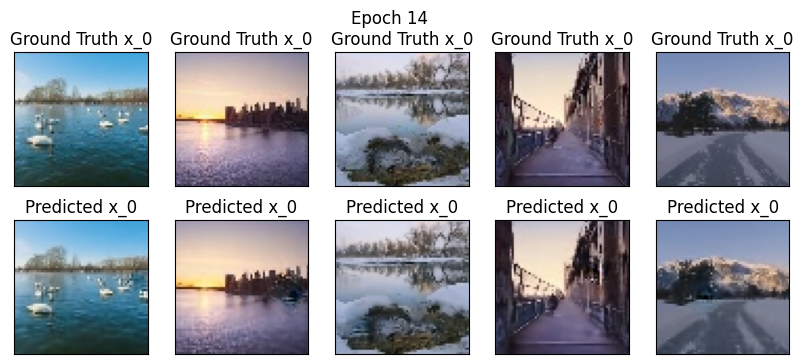

Epoch 15: 100%|██████████| 1894/1894 [01:49<00:00, 17.35it/s, v_num=18, train_loss_step=0.00177, train_loss_epoch=0.00158]
sampling loop


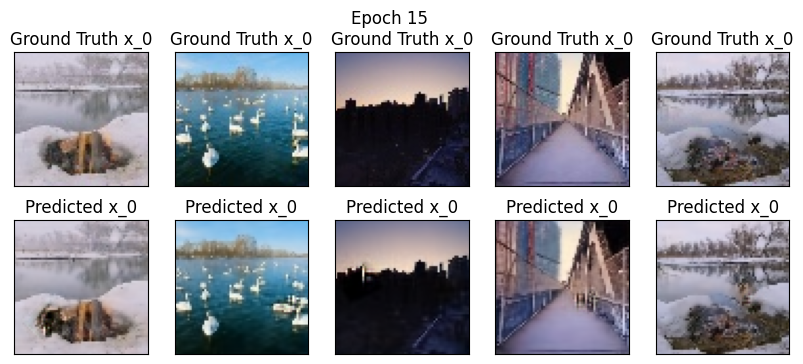

Epoch 16: 100%|██████████| 1894/1894 [01:49<00:00, 17.32it/s, v_num=18, train_loss_step=0.00127, train_loss_epoch=0.00154] 
sampling loop


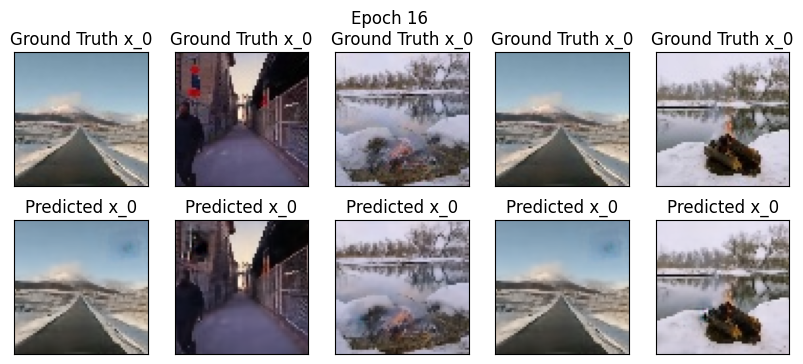

Epoch 17: 100%|██████████| 1894/1894 [01:54<00:00, 16.51it/s, v_num=18, train_loss_step=0.00188, train_loss_epoch=0.00152]
sampling loop


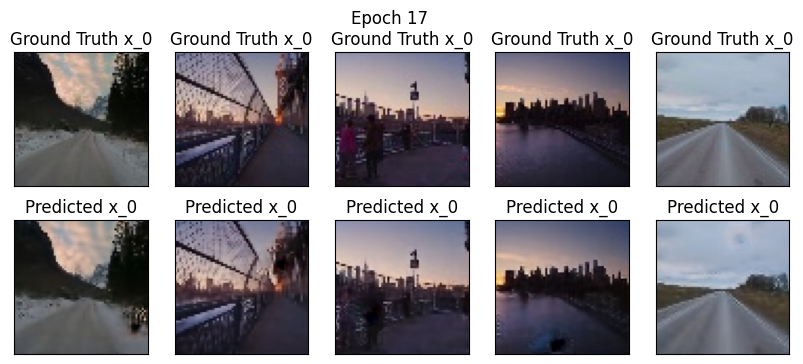

Epoch 18: 100%|██████████| 1894/1894 [01:59<00:00, 15.89it/s, v_num=18, train_loss_step=0.00119, train_loss_epoch=0.00149]
sampling loop


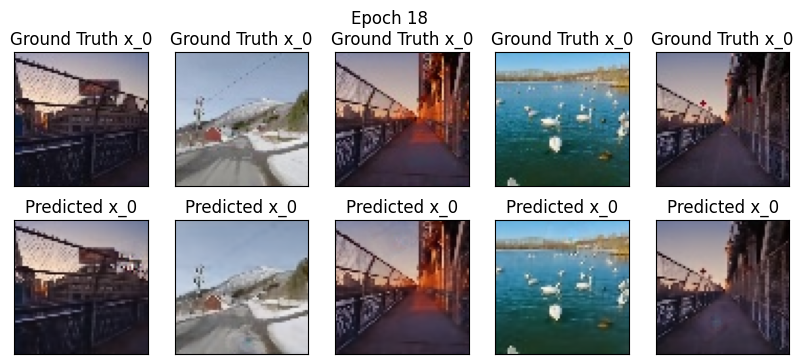

Epoch 19: 100%|██████████| 1894/1894 [01:59<00:00, 15.85it/s, v_num=18, train_loss_step=0.00106, train_loss_epoch=0.00149]
sampling loop


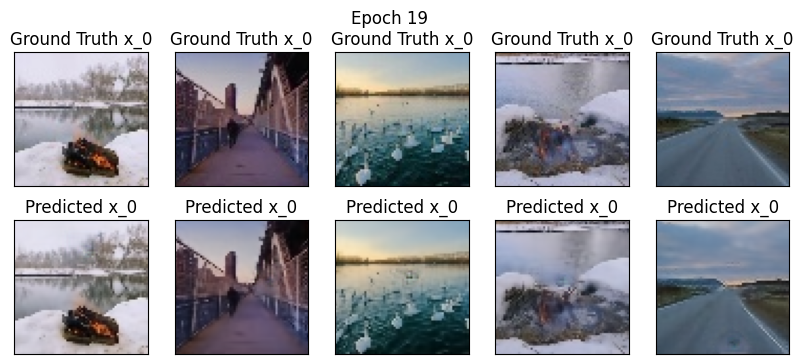

Epoch 20: 100%|██████████| 1894/1894 [01:54<00:00, 16.57it/s, v_num=18, train_loss_step=0.00199, train_loss_epoch=0.00145] 
sampling loop


/mnt/d/Coding/Python/project-nature-inpainting/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [20]:
diffusion = Diffusion(timesteps=1000)
unet_model = UNetDDPM(channels=[32, 64, 128])
lit_model = ModelLit(unet_model, diffusion)

trainer = pl.Trainer(
    devices=[0],
    max_epochs=15, 
    check_val_every_n_epoch=1,
    limit_val_batches=1,
    )

trainer.fit(
    model=lit_model, 
    train_dataloaders=train_loader_pickle, 
    val_dataloaders=val_loader_pickle
    )

In [ ]:
lit_model.loss_log

[0.259537935256958,
 0.004937314428389072,
 0.003965326119214296,
 0.0032766456715762615,
 0.0034182965755462646,
 0.002993137575685978,
 0.003015195019543171,
 0.0030717537738382816,
 0.0030063525773584843]

In [ ]:
%load_ext tensorboard

%tensorboard --logdir lightning_logs/

In [ ]:
def evaluate(model: nn.Module, test_loader: DataLoader) -> None:
    """
    Evaluate the model on a test dataset and display the results.

    This function computes the MSE, NRMSE, PSNR, and SSIM metrics for the model's predictions
    on the test dataset. It also displays the corrupted, predicted, and ground truth images
    for the first 5 samples in the test dataset.

    Parameters
    ----------
    model : nn.Module
        The model to evaluate.
    test_loader : DataLoader
        The DataLoader for the test dataset.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the computed metrics for each sample in the test dataset.
    """
    model.eval()
    fig, axs = plt.subplots(3, 5, figsize=(15, 15))
    metrics = {"MSE": [], "NRMSE": [], "PSNR": [], "SSIM": []}
    with torch.no_grad():
        for idx, (x, y) in enumerate(test_loader):
            x, y = x.to(model.device), y.to(model.device)
            y_pred = model.diffusion.sample(model.model, x, sample_size=x.shape)
            y_pred = y_pred[0].detach().cpu().numpy().transpose(1, 2, 0)
            y_pred = (y_pred + 1) / 2
            y = y[0].detach().cpu().numpy().transpose(1, 2, 0)
            y = (y + 1) / 2
            x = x[0].detach().cpu().numpy().transpose(1, 2, 0)
            x = (x + 1) / 2

            mse = mean_squared_error(y.flatten(), y_pred.flatten())
            nrmse = np.sqrt(mse) / (np.max(y) - np.min(y))
            psnr = peak_signal_noise_ratio(y, y_pred, data_range=y.max() - y.min())
            ssim = structural_similarity(
                y, y_pred, channel_axis=-1, data_range=y.max() - y.min()
            )

            metrics["MSE"].append(mse)
            metrics["NRMSE"].append(nrmse)
            metrics["PSNR"].append(psnr)
            metrics["SSIM"].append(ssim)

            if idx < 5:
                axs[0, idx].imshow(x)
                axs[0, idx].set_title("Corrupted Image")
                axs[1, idx].imshow(y_pred)
                axs[1, idx].set_title("Predicted")
                axs[2, idx].imshow(y)
                axs[2, idx].set_title("Ground Truth")

    plt.show()

    metrics_df = pd.DataFrame(metrics)
    summary = metrics_df.describe()
    mean_min_summary = summary.loc[["max", "mean", "min"]]
    display(mean_min_summary)

    return metrics_df


sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling loop

sampling 

KeyboardInterrupt: 

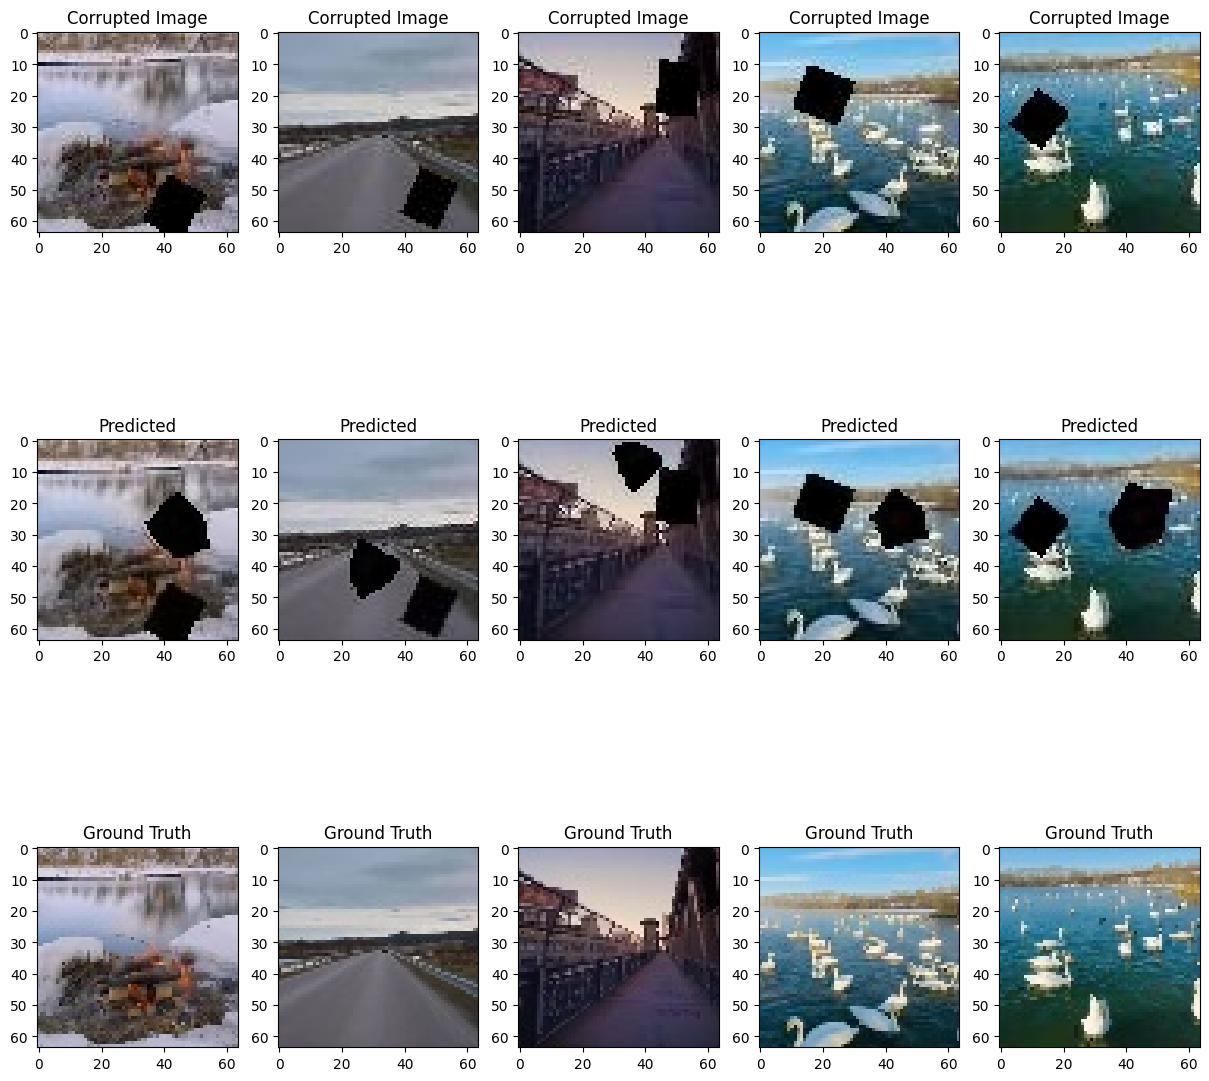

In [ ]:
_ = evaluate(lit_model, test_loader_pickle)